In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive/NN and NLP/lab 11")

Mounted at /content/drive


# Lab 11: Dialogue Act Tagging

Dialogue act (DA) tagging is an essential step in the development of dialog systems. DA tagging is a problem that is usually solved using supervised machine learning techniques, which all require a large amount of manually labeled data. For DA tagging, a variety of methods have been investigated. In this lab, we'll look at two different DA classification models. The Switchboard Dialog Act Corpus is being used for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


The downloaded dataset should be kept in a data folder in the same directory as this file. 

In [ ]:
import pandas as pd
import glob
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [ ]:
f = glob.glob("swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)


In [ ]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [ ]:
reduced_df = result[['act_tag','text']]


Reduce the number of tags to 43 by combining them and converting them to generic tags.

In [ ]:
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else: 
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)            
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

In [ ]:
reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


This dataset contains 43 tags. Yes-No-Question ('qy'), Statement-non-opinion ('sd'), and Statement-opinion ('sv') are some of the tags. Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags. 


You can check the frequency of tags.

To get unique tags:

In [ ]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [ ]:
one_hot_encoding_dic = pd.get_dummies(list(unique_tags))


In [ ]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [ ]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [ ]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [ ]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


The dataset is divided into two sections: test and training.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding),shuffle=False, stratify=None)


Pad each utterance to make them all the same length.




In [ ]:
MAX_LENGTH = 150

In [ ]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

In [ ]:
# Split Train into Train and Validation - about 10% into validation - In order to validate the model as it is training

train_input = train_sentences_X[:140000]
val_input = train_sentences_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]


In [ ]:
train_input[11050]


array([ 750,  631,   96,  645,   31,  127,   48, 4796,   27,    3,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], d

In [ ]:
sentence_embeddings[11050]

[750, 631, 96, 645, 31, 127, 48, 4796, 27, 3]

# Model 1 - 

This first model has an architecture of:

- Embedding  
- BLSTM  
- Fully Connected Layer
- Softmax Activation

The model architecture is as follows: Embedding Layer (to generate word 
embeddings). Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get probabilities.


In [ ]:
VOCAB_SIZE = len(wordvectors)+1 # 43,731
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, Activation, Embedding, Lambda
import tensorflow as tf
import keras
from keras import backend as K


#Building the network
model = keras.Sequential()
model.add(InputLayer(MAX_LENGTH,name="layer1"))
model.add(Embedding(VOCAB_SIZE,EMBED_SIZE, name="layer2"))          # Embedding layer
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))  # Bidirectional 1
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=False))) # Bidirectional 2
model.add(Dense(HIDDEN_SIZE))                                       # Dense layer
model.add(Activation(tf.keras.activations.softmax))                 # Activation
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer2 (Embedding)          (None, 150, 100)          4373200   
                                                                 
 bidirectional (Bidirectiona  (None, 150, 86)          49536     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 86)               44720     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 43)                3741      
                                                                 
 activation (Activation)     (None, 43)                0         
                                                                 
Total params: 4,471,197
Trainable params: 4,471,197
Non-

In [ ]:
# Train the model - use validation 
history = model.fit(train_input, train_labels, epochs=10, batch_size=100, validation_data=(val_input,val_labels),verbose=1)

Epoch 1/10
1400/1400 [==============================] - 69s 43ms/step - loss: 1.3306 - accuracy: 0.6200 - val_loss: 1.1561 - val_accuracy: 0.6564
Epoch 2/10
1400/1400 [==============================] - 60s 43ms/step - loss: 0.9541 - accuracy: 0.7176 - val_loss: 1.0341 - val_accuracy: 0.6855
Epoch 3/10
1400/1400 [==============================] - 60s 43ms/step - loss: 0.8238 - accuracy: 0.7540 - val_loss: 1.0134 - val_accuracy: 0.6920
Epoch 4/10
1400/1400 [==============================] - 59s 42ms/step - loss: 0.7441 - accuracy: 0.7731 - val_loss: 1.0266 - val_accuracy: 0.6909
Epoch 5/10
1400/1400 [==============================] - 59s 42ms/step - loss: 0.6822 - accuracy: 0.7900 - val_loss: 1.0580 - val_accuracy: 0.6845
Epoch 6/10
1400/1400 [==============================] - 59s 42ms/step - loss: 0.6307 - accuracy: 0.8047 - val_loss: 1.1029 - val_accuracy: 0.6812
Epoch 7/10
1400/1400 [==============================] - 59s 42ms/step - loss: 0.5909 - accuracy: 0.8156 - val_loss: 1.1209 -

In [ ]:
score = model.evaluate(test_sentences_X, y_test, batch_size=100)

560/560 [==============================] - 9s 17ms/step - loss: 1.1981 - accuracy: 0.6909


In [ ]:
print("Test Accuracy:", score[1]*100)

Test Accuracy: 69.09233927726746


## Evaluation




You should look at the accuracy of some minority classes in addition to overall accuracy. Signal-non-understanding ('br') is a good indicator of "other-repair," or situations in which the other conversational participant tries to correct the speaker's mistake. In dialogue summarization, the term "summarize/reformulate" ('bf') has been used. Report on the system's accuracy in predicting these classes, as well as any common errors you notice. 

## Minority Classes

In [ ]:
# Generate predictions for the test data|
test_preds = model.predict(test_sentences_X)

In [ ]:
# Build the confusion matrix off these predictions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_test.argmax(axis=1), test_preds.argmax(axis=1))
acc_all = matrix.diagonal()/matrix.sum(axis=1)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), test_preds.argmax(axis=1)))
print(precision_recall_fscore_support(y_test.argmax(axis=1), test_preds.argmax(axis=1), average='macro'))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77     19663
           1       0.79      0.62      0.69       587
           2       0.63      0.59      0.61        37
           3       0.21      0.25      0.23       161
           4       0.17      0.01      0.02       193
           5       0.65      0.46      0.54       151
           6       0.00      0.00      0.00        78
           7       0.50      0.14      0.22        43
           8       0.44      0.03      0.06       732
           9       0.14      0.18      0.16        22
          10       0.72      0.34      0.46       140
          11       0.38      0.07      0.11        74
          12       0.10      0.15      0.12       104
          13       0.09      0.06      0.07       324
          14       0.60      0.28      0.38        32
          15       0.82      0.80      0.81      3945
          16       0.12      0.09      0.10       203
          17       0.77    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Below confusion matrix function is used from NLP Module from semester 1 lab 3.

In [ ]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(20,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(list(unique_tags))
    ax.set_yticklabels(list(unique_tags))

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    plt.show() 

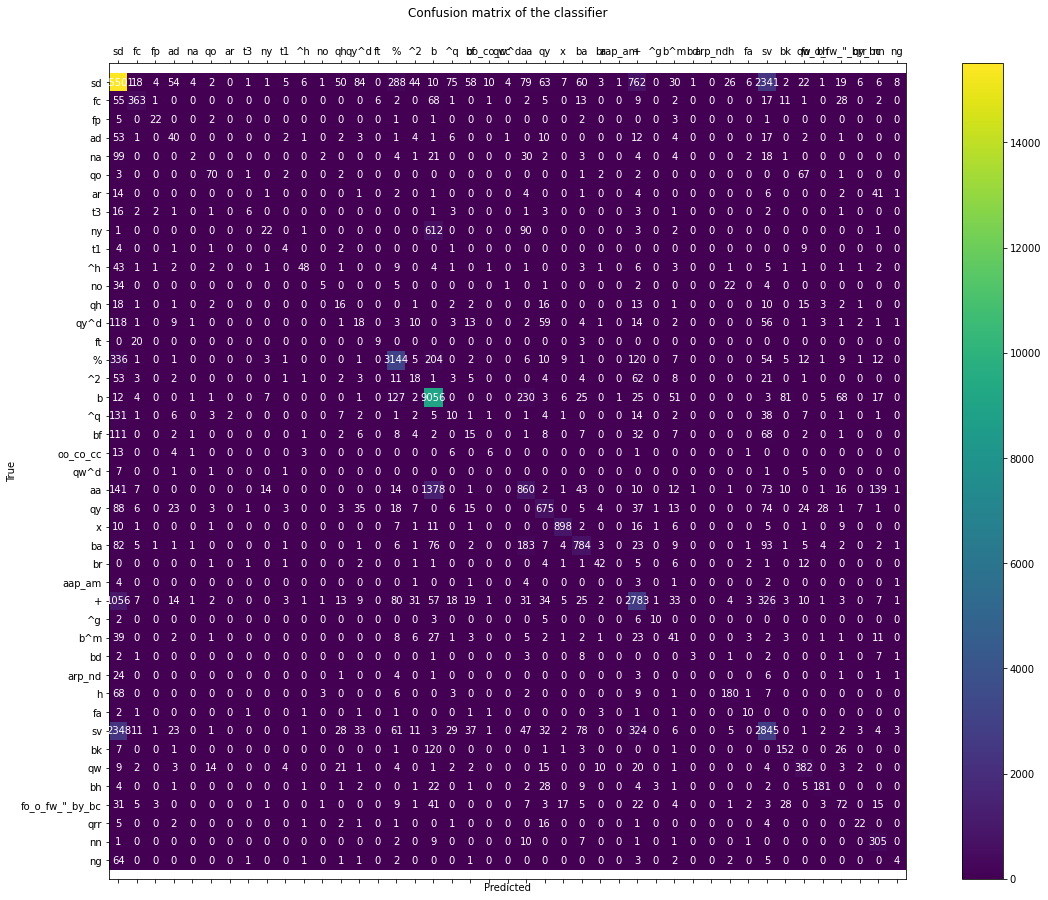

In [ ]:
confusion_matrix_heatmap(y_test.argmax(axis=1), test_preds.argmax(axis=1))

In [ ]:
br_index = list(unique_tags).index('br')
bf_index = list(unique_tags).index('bf')
br_index, bf_index

(26, 19)

In [ ]:
# Calculate Accuracies for "br" and "bf"
print(f'The accuracy for class br is {acc_all[br_index]*100} whereas that of class bf is {acc_all[bf_index]*100}')

The accuracy for class br is 51.85185185185185 whereas that of class bf is 5.39568345323741


## Minority Classes



Minority classes are frequently misidentified as majority classes, owing to the fact that majority classes have significantly more data and thus can be trained on. With 33 percent and 17 percent, respectively, the classes "sd" (40) and "b" (10) are the most common here. 




## Minority Class showcase
The frequencies of the data are plotted in the graph below. This illustrates how some classes are common, while the majority of classes are rare. 

Only 0.13 percent of the data belongs to the "br" class, while 0.42 percent belongs to the "bf" class. 

In [ ]:
# Print the frequency of the "br" and "bf" classes
value_counts = reduced_df["act_tag"].value_counts()
bf_frequency = value_counts["bf"]/sum(value_counts)
print("bf frequency: " + str(bf_frequency*100) + "%")

br_frequency = value_counts["br"]/sum(value_counts)
print("br frequency: " + str(br_frequency*100) + "%")

bf frequency: 0.42977379855638936%
br frequency: 0.13371734211067682%


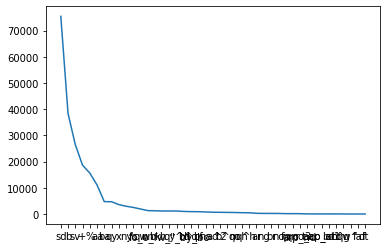

In [ ]:
# Plot the frequencies of the classes
plt.plot(value_counts)

# Model 2 - Balanced Network


As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training. 

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))

## Define & Train the model

In [ ]:
# Re-built the model for the balanced training

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, Activation, Embedding, Lambda
import tensorflow as tf
import keras
from keras import backend as K


#Building the network

# Include 2 BLSTM layers, in order to capture both the forward and backward hidden states

# Embedding layer
# Bidirectional 1
# Bidirectional 2
# Dense layer
# Activation

model_balanced = keras.Sequential()
model_balanced.add(InputLayer(MAX_LENGTH,name="layer1"))
model_balanced.add(Embedding(VOCAB_SIZE,EMBED_SIZE, name="layer2"))
model_balanced.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model_balanced.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=False)))
model_balanced.add(Dense(HIDDEN_SIZE))
model_balanced.add(Activation(tf.keras.activations.softmax))
model_balanced.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model_balanced.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer2 (Embedding)          (None, 150, 100)          4373200   
                                                                 
 bidirectional_2 (Bidirectio  (None, 150, 86)          49536     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 86)               44720     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 43)                3741      
                                                                 
 activation_1 (Activation)   (None, 43)                0         
                                                                 
Total params: 4,471,197
Trainable params: 4,471,197
No

In [ ]:
# Train the balanced network - Seems to take long time to achieve good accuracy?
history_balanced = model_balanced.fit(train_input, train_labels, epochs=10, batch_size=100, class_weight = d_class_weights, validation_data=(val_input,val_labels),verbose=1)

Epoch 1/10
1400/1400 [==============================] - 63s 42ms/step - loss: 2.9562 - accuracy: 0.2635 - val_loss: 2.4282 - val_accuracy: 0.2870
Epoch 2/10
1400/1400 [==============================] - 59s 42ms/step - loss: 2.1311 - accuracy: 0.3907 - val_loss: 2.0859 - val_accuracy: 0.4298
Epoch 3/10
1400/1400 [==============================] - 58s 42ms/step - loss: 1.6960 - accuracy: 0.4446 - val_loss: 2.0355 - val_accuracy: 0.4190
Epoch 4/10
1400/1400 [==============================] - 60s 43ms/step - loss: 1.4259 - accuracy: 0.4700 - val_loss: 1.9624 - val_accuracy: 0.3997
Epoch 5/10
1400/1400 [==============================] - 59s 42ms/step - loss: 1.2115 - accuracy: 0.4962 - val_loss: 1.7686 - val_accuracy: 0.4772
Epoch 6/10
1400/1400 [==============================] - 60s 43ms/step - loss: 1.0550 - accuracy: 0.5159 - val_loss: 2.1080 - val_accuracy: 0.3904
Epoch 7/10
1400/1400 [==============================] - 59s 42ms/step - loss: 0.9400 - accuracy: 0.5446 - val_loss: 1.9775 -

## Test the model

In [ ]:
# Overall Accuracy
score_balanced = model_balanced.evaluate(test_sentences_X, y_test, batch_size=100)

560/560 [==============================] - 9s 17ms/step - loss: 1.7931 - accuracy: 0.4596


In [ ]:
print("Overall Accuracy:", score_balanced[1]*100)

Overall Accuracy: 45.96436619758606


In [ ]:
# Generate predictions for the test data
label_pred = model_balanced.predict(test_sentences_X, batch_size=100)

## Balanced network evaluation

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

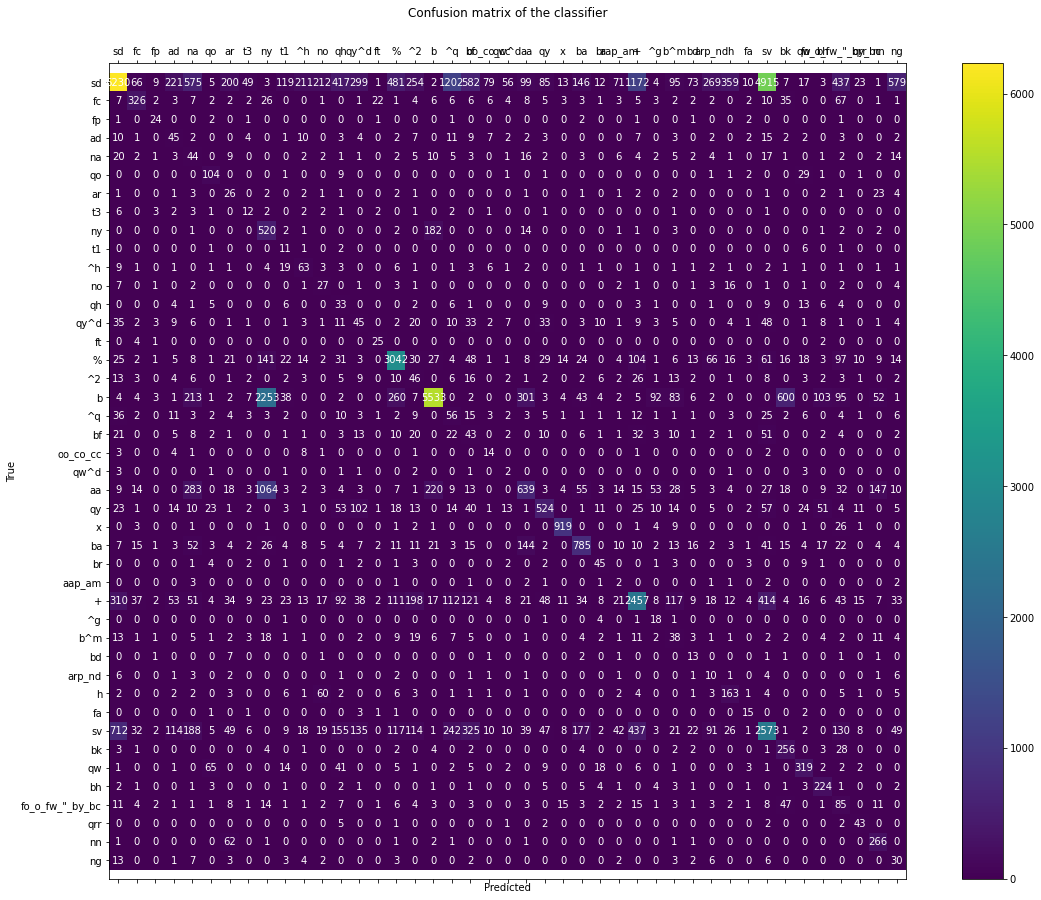

In [ ]:
# Build the confusion matrix off these predictions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix_balanced = confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1))
balanced_acc_all = matrix_balanced.diagonal()/matrix_balanced.sum(axis=1) # computes accuracies for all the classes
confusion_matrix_heatmap(y_test.argmax(axis=1), label_pred.argmax(axis=1))

In [ ]:
# Calculate Accuracies for "br" and "bf"
br_index = list(unique_tags).index('br')
bf_index = list(unique_tags).index('bf')
print(f'The accuracy for class br is {balanced_acc_all[br_index]*100} whereas that of class bf is {balanced_acc_all[bf_index]*100}')

The accuracy for class br is 55.55555555555556 whereas that of class bf is 15.467625899280577






### Explanation



### Other ways to handle imbalanced classes




## Here are some ways by which we can handle the imbalanced classes:-

1. Synthetic Minority Oversampling Technique (SMOTE) is a method to oversample the minority class. Basically adding copy records of minority class frequently add no new data to the model. In SMOTE new occurrences are blended from the current information. Assuming we make sense of it in straightforward words, SMOTE investigates minority class occasions and utilize k closest neighbor to choose an arbitrary closest neighbor, and an engineered case is made haphazardly in include space.

2. Resampling (Undersampling or Oversampling). This strategy is used to upsample or downsample the minority or greater part class. Whenever we are using an imbalanced dataset, we can oversample the minority class using substitution. This strategy is called oversampling. Essentially, we can arbitrarily erase lines from the larger part class to coordinate them with the minority class which is called undersampling. In the wake of examining the information we can get a fair dataset for both greater part and minority classes. In this way, when the two classes have a comparative number of records present in the dataset, we can expect that the classifier will give equivalent significance to the two classes.

Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of 
previous DA tags, plus the utterance representation. 

# Using Context for Dialog Act Classification
We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each utterance for DA classification. Here, we use bidirectional-LSTM (BLSTM) to learn the context before and after the current utterance. 

To make it easier to train, we combined all of the utterances into one long sequence rather than breaking them up into individual dialogues.

## Define the model

This model has an architecture of:

- Word Embedding
- CNN
- Bidirectional LSTM
- Fully-Connected output


## CNN


This is classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN. We transform/reshape conv output to 2d matrix. Then we pass it to the max pooling layer that applies the max pool operation on windows of different sizes.

In [ ]:
import tensorflow
import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input,LSTM
from tensorflow.keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape, Conv2D, BatchNormalization,MaxPool2D,Concatenate, Flatten


filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors)+1 # 43,731
MAX_LENGTH = 150
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

# CNN model
inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_LENGTH)(inputs)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

# 3 convolutions
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_0 = BatchNormalization()(conv_0)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

# maxpool for 3 layers
maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

In [ ]:
# concatenate tensors
concat = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
# flatten concatenated tensors
flatten = Flatten()(concat)
# dense layer (dense_1)
dense_1 = Dense(HIDDEN_SIZE, activation='relu')(flatten)
# dropout_1
dropout_1 = Dropout(drop)(dense_1)

## BLSTM

This is used to create LSTM layers. The data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You should create a BiLSTM.
    

In [ ]:
# BLSTM model

inputs_lstm = Input(shape=(MAX_LENGTH, ), dtype='int32')
# embedding_lstm = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_LENGTH)(inputs_lstm)
embedding_lstm = Embedding(VOCAB_SIZE,EMBED_SIZE)(inputs_lstm)

# Bidirectional 1
lstm1 = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True))(embedding_lstm)

# Bidirectional 2
lstm2 = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=False))(lstm1)
# Dense layer (dense_2)
dense_2 = Dense(HIDDEN_SIZE, activation = 'relu')(lstm2)
# dropout_2
dropout_2 = Dropout(drop)(dense_2)


Concatenate 2 last layers and create the output layer
network

In [ ]:
# concatenate 2 final layers
model_cnn = Model(inputs=inputs, outputs=dropout_1)
model_lstm = Model(inputs=inputs_lstm, outputs=dropout_2)

final = Concatenate(axis=1)([model_cnn.output,model_lstm.output])
output = Dense(HIDDEN_SIZE,activation='softmax')(final)

model2 = Model(inputs=[model_cnn.input,model_lstm.input],outputs=output)
model2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 150, 100)     4373200     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 150, 100, 1)  0           ['embedding[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 148, 1, 64)   19264       ['reshape[0][0]']                
                                                                                            

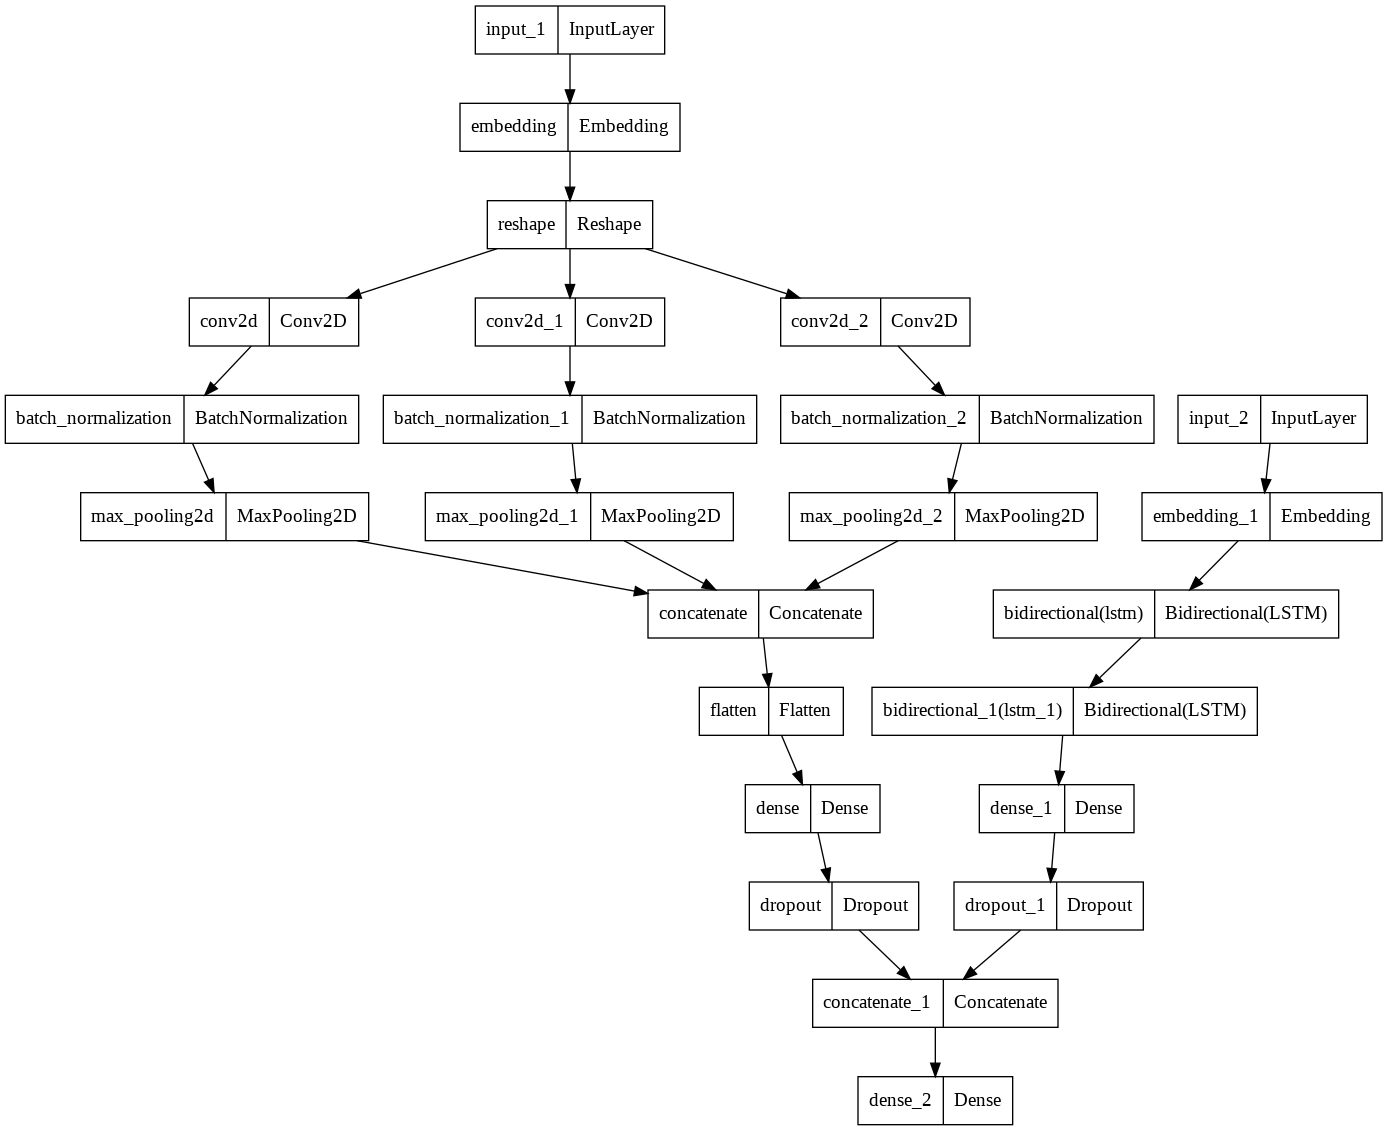

In [ ]:
tf.keras.utils.plot_model(
    model2,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

Report your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.
layer

In [ ]:
# Train the model - use validation 
history_cnn_lstm = model2.fit([train_input,train_input], train_labels, epochs=10, batch_size=100, validation_data=([val_input,val_input],val_labels),verbose=1)

Epoch 1/10
1400/1400 [==============================] - 96s 56ms/step - loss: 1.1144 - accuracy: 0.6712 - val_loss: 0.9813 - val_accuracy: 0.7024
Epoch 2/10
1400/1400 [==============================] - 75s 53ms/step - loss: 0.8283 - accuracy: 0.7435 - val_loss: 0.9741 - val_accuracy: 0.7070
Epoch 3/10
1400/1400 [==============================] - 76s 55ms/step - loss: 0.6942 - accuracy: 0.7822 - val_loss: 1.0085 - val_accuracy: 0.7103
Epoch 4/10
1400/1400 [==============================] - 77s 55ms/step - loss: 0.5947 - accuracy: 0.8103 - val_loss: 1.1021 - val_accuracy: 0.6938
Epoch 5/10
1400/1400 [==============================] - 77s 55ms/step - loss: 0.5248 - accuracy: 0.8300 - val_loss: 1.2297 - val_accuracy: 0.6902
Epoch 6/10
1400/1400 [==============================] - 78s 55ms/step - loss: 0.4780 - accuracy: 0.8438 - val_loss: 1.2861 - val_accuracy: 0.6860
Epoch 7/10
1400/1400 [==============================] - 78s 56ms/step - loss: 0.4479 - accuracy: 0.8527 - val_loss: 1.3877 -

In [ ]:
score = model2.evaluate([test_sentences_X,test_sentences_X], y_test, batch_size=100)

560/560 [==============================] - 11s 20ms/step - loss: 1.5077 - accuracy: 0.6972


In [ ]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 69.72201466560364


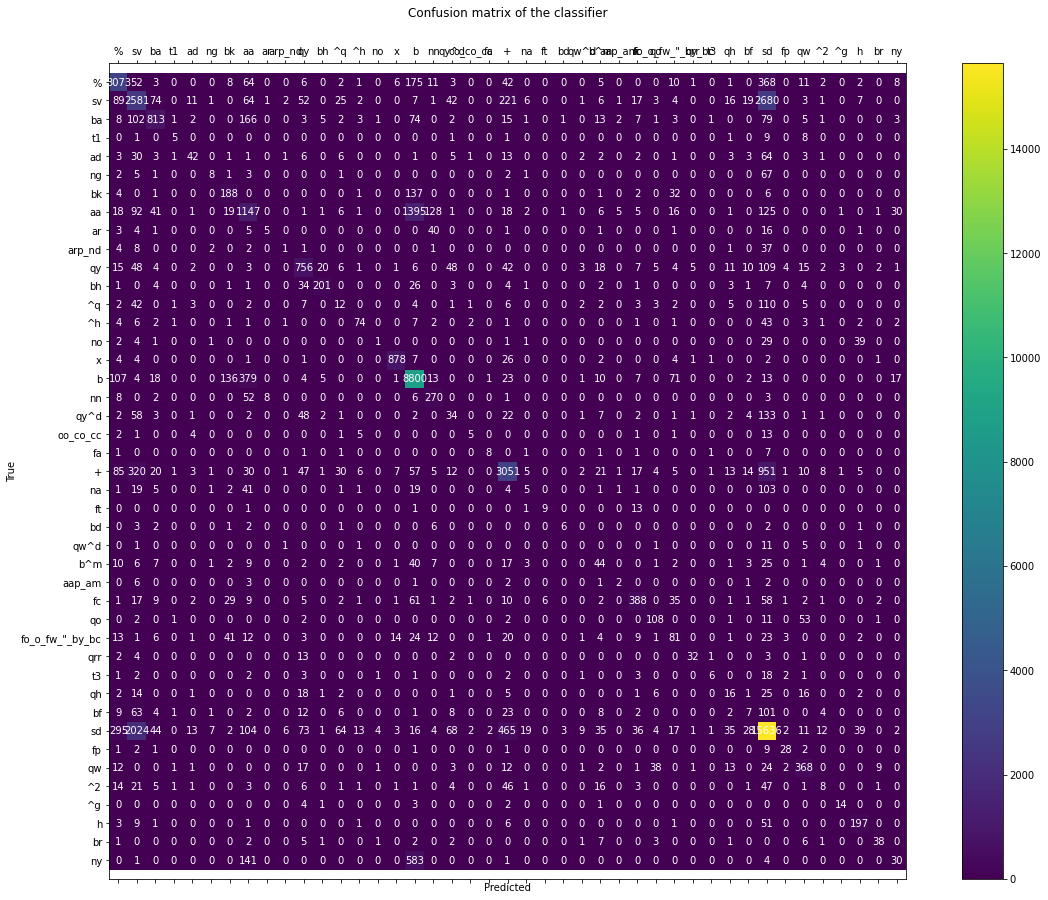

In [ ]:
label_pred2 = model2.predict([test_sentences_X,test_sentences_X], batch_size=100)
# Build the confusion matrix off these predictions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix_2= confusion_matrix(y_test.argmax(axis=1), label_pred2.argmax(axis=1))
acc_2 = matrix_2.diagonal()/matrix_2.sum(axis=1) # computes accuracies for all the classes
confusion_matrix_heatmap(y_test.argmax(axis=1), label_pred2.argmax(axis=1))

In [ ]:
# Calculate Accuracies for "br" and "bf" for the hierarchical utterance+DA-context-based tagger model
br_index = list(unique_tags).index('br')
bf_index = list(unique_tags).index('bf')
print(f'The accuracy for class br is {acc_2[br_index]*100} whereas that of class bf is {acc_2[bf_index]*100}')

The accuracy for class br is 53.52112676056338 whereas that of class bf is 2.7559055118110236
